In [32]:
import cv2
import numpy as np
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

In [33]:
def removeLines(img):
    image= cv2.imread(img,0) # reads image as grayscale

    # use gaussian filter to smooth the image
    binary= cv2.GaussianBlur(image,(3,3),10)


    # use otsu thresholding for accurate conversion to binary image
    thresh = threshold_otsu(image)
    binary = image > thresh

    # convert binary image to uint8 with 255 as white and 0 as black
    binary = binary.astype(np.uint8)*255
    binary_inv = cv2.bitwise_not(binary)
    # Identifying the horizontal lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    detected_lines = cv2.morphologyEx(binary_inv, cv2.MORPH_OPEN,
    horizontal_kernel, iterations=1)

    # dialate the detected lines
    detected_lines = cv2.dilate(detected_lines, np.ones((3,2)), iterations=1)

    # Erode the detected lines
    detected_lines = cv2.erode(detected_lines, np.ones((3,2)), iterations=1)

    # invert the detected lines lengthwise
    detected_lines = cv2.dilate(detected_lines, np.ones((1,5)), iterations=1)

    # GaussianBlur the detected lines
    detected_lines= cv2.GaussianBlur(detected_lines,(3,3),10)
    detected_lines_inv = cv2.bitwise_not(detected_lines)
    

    plt.imshow(detected_lines, cmap='gray')
    plt.title('Detected Lines')
    plt.axis('off')
    plt.show()

    newimg= cv2.inpaint(image,detected_lines,1,cv2.INPAINT_TELEA)
    plt.imshow(newimg, cmap='gray',)
    plt.title('Inpainted Image')
    plt.axis('off')
    plt.show()

    plt.imsave('output1.jpg',newimg,cmap='gray')

    return newimg

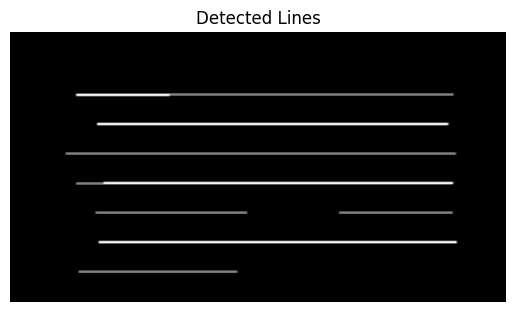

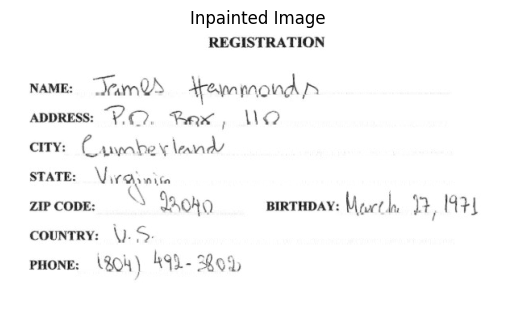

In [34]:
lines_removed=removeLines('document.jpg')

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def text_segmentation(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding to obtain a binary image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # dialation of image
    binary=cv2.dilate(binary, np.ones((3,15)), iterations=1)
    plt.imshow(binary,cmap="gray")
    plt.show()
    
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
    
    # Initialize list to store word bounding boxes
    word_boxes = []
    for label in range(1, num_labels):
        x, y, w, h, area = stats[label] 
        if area < 100: 
            continue
        word_boxes.append((x+2, y, w-2, h))
        cv2.rectangle(image, (x+2, y), (x + w-2, y + h), (0, 255, 0), 2)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Segmented Text with Bounding Boxes')
    plt.axis('off')
    
    # Save the displayed image
    output2_path = 'output2.jpg'
    plt.savefig(output2_path)
    print("Segmented image with bounding boxes saved as:", output2_path)
    
    # Show the displayed image
    plt.show()
    
    # Save the segmented image with bounding boxes
    cv2.imwrite('output2_opencv.jpg', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    print("Segmented image with bounding boxes saved as: output2_opencv.jpg")
    
    return word_boxes


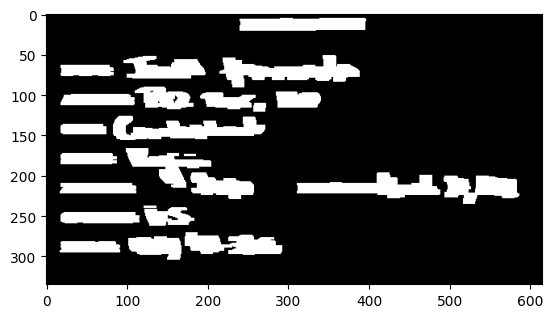

Segmented image with bounding boxes saved as: output2.jpg


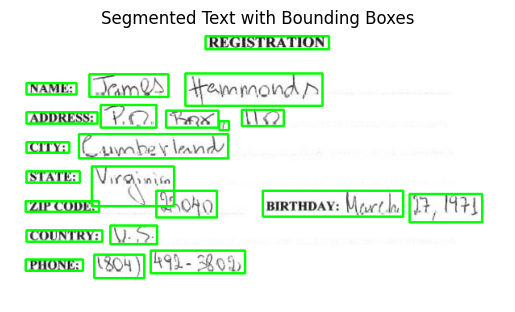

Segmented image with bounding boxes saved as: output2_opencv.jpg


In [55]:
boundingBoxes=text_segmentation("output1.jpg")

In [56]:
len(boundingBoxes)

22

In [80]:
# density of black pixels in bounding boxes
def featureExtraction():
    thresh = threshold_otsu(lines_removed)
    binary = lines_removed > thresh

        # convert binary image to uint8 with 255 as white and 0 as black
    binary = binary.astype(np.uint8)*255
    counts=[]
    for box in boundingBoxes:
        count=0
        for x in range(box[0],box[0]+box[2]):
            for y in range(box[1],box[1]+box[3]):
                if(binary[y][x]==0):
                    count+=1
        counts.append(count/(box[2]*box[3]))
    print(counts)

    meanWidth=np.mean([box[2] for box in boundingBoxes])
    meanHeight=np.mean([box[3] for box in boundingBoxes])
    meanArea=np.mean([box[2]*box[3] for box in boundingBoxes])
    widthDeviations=[abs(box[2]-meanWidth) for box in boundingBoxes]
    heightDeviations=[abs(box[3]-meanHeight) for box in boundingBoxes]
    areaDeviations=[abs(box[2]*box[3]-meanArea) for box in boundingBoxes]

    blackPixelsofEachLine=compute_black_pixels_of_each_line(binary,boundingBoxes[10])
    print(blackPixelsofEachLine)




In [75]:
def compute_black_pixels_of_each_line(image, box):

    # Get the bounding box of the image
    x, y, w, h =box

    # Divide the bounding box vertically into lines
    line_features = []

    for i in range(h):
        line_y = y + i
        line_roi = image[line_y, x:x + w]

        # Count black pixels in the line
        black_pixels = np.sum(line_roi <= 128)

        # Calculate ratio of black pixels to BB width for the line
        line_feature = black_pixels / w
        line_features.append(line_feature)

    # Sum up the ratios as the feature value
    black_pixels_feature = sum(line_features)

    return black_pixels_feature

In [76]:
print(boundingBoxes[10])


(20, 137, 55, 13)


0.0
0.45454545454545453
0.2727272727272727
0.2
0.23636363636363636
0.2545454545454545
0.23636363636363636
0.2
0.21818181818181817
0.2
0.23636363636363636
0.38181818181818183
0.0


2.8909090909090907

In [81]:
featureExtraction()

[0.3810483870967742, 0.15464285714285714, 0.10203488372093024, 0.3169642857142857, 0.11167002012072434, 0.15, 0.1656005685856432, 0.4, 0.06493506493506493, 0.10909090909090909, 0.2811188811188811, 0.08437990580847723, 0.3245798319327731, 0.12317985045257772, 0.1514559659090909, 0.10838509316770187, 0.3738626964433416, 0.10217391304347827, 0.33407738095238093, 0.12725090036014405, 0.1341594827586207, 0.37181996086105673]
0.0
0.5636363636363636
0.4
0.2909090909090909
0.2727272727272727
0.3090909090909091
0.3090909090909091
0.23636363636363636
0.21818181818181817
0.2909090909090909
0.32727272727272727
0.43636363636363634
0.0
3.6545454545454548
